# Logistic Regression

This notebook builds a logitstic regression model to predict whether or not a song will be a hit or not based on its audio features as classified by Spotify (e.g. duration_ms, danceability, liveness etc.). A song is defined as successful if it achieves a minimum popularity score of 50. All data has been collected using Spotify's API as accessed through python's SpotiPy library - this is fully detailed in the prior notebook using the script defined in `scripst/get_spotify_data.py`.

Time permitting, I hope to extend the accuracy of this initial classification using Billboard's API, by defining a song as a hit if it appears in their top / hot 100. As I am aware that defining success based purely on Spotify's popularity classification is not a fair measure of a song's success.

This notebook is divided out as follows:

  - 2.1 Feature Engineering
  - 2.2 Logistic Regression Model
  - 2.3 Hyperparameter Tuning
  - 2.4 Final Model

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, f1_score
from sklearn.metrics import classification_report
%pip install vaderSentiment  --quiet
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/MyDrive/spotify/scripts/

     |████████████████████████████████| 133kB 7.7MB/s 
Mounted at /content/gdrive
/content/gdrive/MyDrive/spotify/scripts


## Feature Engineering

I have begun by creating a series of features to help my model with its classification:

- `hit?` - If a song has a `popularity > 50` it is defined as a hit (1) else 0.
- `year` - Stripping `release_date` to just the year of release.
- `sentiment` - Sentiment of `name` as classified using VADER.

I have then checked for any NaN values and replaced these with the mean value of that column while dropping any non-numeric features.

In [2]:
df = pd.read_csv("../data/master_data.csv")
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
hit_cutoff = 50
df['hit?'] = df['popularity'].apply(lambda x: 1 if x>=hit_cutoff else 0)
print(df['hit?'].value_counts(normalize=True))

df['year'] = df['release_date'].apply(lambda x: int(x[:4]))
# Sentiment analysis of track title using VADER
analyser = SentimentIntensityAnalyzer()
df['sentiment'] = df['name'].apply(lambda x:
                                   analyser.polarity_scores(x)['compound'])

0    0.872103
1    0.127897
Name: hit?, dtype: float64


We see here that our dataset has ended up being unbalanced, with ~13% of songs defined as hits (popularity > 50). This will need to be accounted for in training by weighting our classes to prevent the model from underfitting to the dataset.

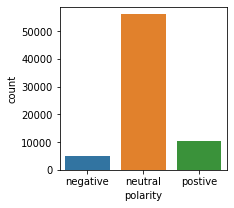

In [3]:
cut_bins = [-1, -0.33, 0.33, 1]
cut_labels = ["negative", "neutral", "postive"]

sentiment_df = pd.DataFrame()
sentiment_df['polarity'] = pd.cut(df['sentiment'], bins=cut_bins,
                                  labels=cut_labels)

plt.figure(figsize=(3,3))
sns.countplot(x='polarity', data=sentiment_df)
plt.show()

Due to the generally short song names and the lack of any context, most songs have been assigned a 'neutral' sentiment.

In [4]:
#replace duartion NaNs with the mean column value.
duration_mean = df['duration_ms'].mean()
df['duration_ms'].fillna(duration_mean, inplace=True)
# Check for nulls or NaNs before training
print(pd.isnull(df).sum())

artist_name         0
album               0
track_number        0
id                  0
name                0
uri                 0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
duration_ms         0
release_date        0
popularity          0
hit?                0
year                0
sentiment           0
dtype: int64


To speed up the convergence of my algorithm, I have normalised all my input features. This will become particularly important later on when building neural networks to prevent exploding / vanishing gradients.

In [5]:
# Drop text features and normalise the remaining numeric features.
df.drop(labels=["track_number", "artist_name", "year", "album", "name", "id",
                "uri", "release_date"], axis=1, inplace=True)

from sklearn.preprocessing import MinMaxScaler
x = df.values
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns = [*audio_features, "duration_ms", 
                                       "popularity", "hit?", "sentiment"])
print(df.columns)

Index(['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence',
       'duration_ms', 'popularity', 'hit?', 'sentiment'],
      dtype='object')


## Logistic Regression Model

To begin training our model, we first must split the data into test and train sets. I have then defined a helper function to plot the confusion matrix given a set of predictions and actual values.

In [6]:
x = df.drop(["hit?", "popularity"], axis=1)
y = df.loc[:,"hit?"].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms,popularity,hit?,sentiment
0,0.338353,0.763931,0.352339,0.000012,0.1760,0.777889,0.094416,0.304641,0.757789,0.032415,0.069767,0.0,0.492009
1,0.188754,0.660588,0.472462,0.196393,0.0974,0.790692,0.116856,0.337357,0.753769,0.034388,0.046512,0.0,0.492009
2,0.652610,0.601824,0.494484,0.000002,0.0913,0.835106,0.055636,0.551861,0.442211,0.052423,0.069767,0.0,0.492009
3,0.915663,0.270517,0.177161,0.000011,0.1050,0.705642,0.039090,0.332657,0.202010,0.049987,0.034884,0.0,0.492009
4,0.312248,0.746707,0.295281,0.000000,0.1410,0.788773,0.166494,0.292026,0.704523,0.055541,0.046512,0.0,0.534119


In [7]:
def conf_matrix(y_test, pred_test):    
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    plt.figure(figsize=(3,3))
    sns.set(font_scale=1) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 12}, fmt='g',
                cmap='Blues', cbar=False)
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    plt.show()

### Class Imbalance

When training our algorithm, the severe class imbalance needs to be accounted for to create a model that properly fits the data. Using accuracy would not be a suitable metric to define performance, as naively the model could achieve around 87% accuracy just by classifying everything as not being not a hit. Sci-kit learn has a number of default class weightings:

`"None"` 
- Each class is assigned an equal weighting, in the case of a highly imbalanced dataset like we have this will result in the majority class dominating in classification.
- Below shows its confusion matrix, everything has been classified as not a hit.
- This is further reflected by the model's F1 score of 0 - a metric combining the precision and recall of the model - this isis indicative that we are not fitting to the data at all.

`"balanced"`
- Balanced class weighting will adjust the class weighting inversely proportional to the frequencies of each class.
- This will assign a higher penalty to misclassifying a hit (class 1) and has resulted in a model that fits the dataset better.
- This has still resulted in a rather low precision, with only 20% of classified hits being true hits.

We ideally want to maximise the precision of song classification as hits. Due to the high cost in promoting and marketing songs, we only want to make this investment if a song truly has the potential to be a hit.

CLASS WEIGHT: None
F1 SCORE: 0.0007309941520467837
PRECISION: 1.0



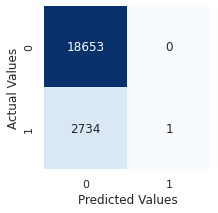

CLASS WEIGHT: balanced
F1 SCORE: 0.30790982640798054
PRECISION: 0.19607843137254902



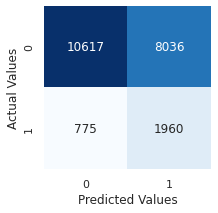

In [8]:
for class_weight in ["None", "balanced"]:
  model = LogisticRegression(solver="newton-cg", class_weight=class_weight,
                             max_iter=1000)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  print(f"CLASS WEIGHT: {class_weight}")
  print(f"F1 SCORE: {f1_score(y_test, y_pred)}")
  print(f"PRECISION: {precision_score(y_test, y_pred, zero_division=0)}\n")
  conf_matrix(y_test, y_pred)

## Hyperparameter Tuning

The `balanced` option seems like a reasonable heuristic for accounting for class imbalanced, although I have also performed a 5-fold stratified grid search over the class weighting parameter space from 0 - 1, with the goal of maximising the resultant model's F1 score.

In [9]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

model = LogisticRegression(solver='newton-cg', penalty="l2")
weights = np.linspace(0,0.99,200)
weights_grid = [{1:x, 0:1.0-x} for x in weights]
param_grid = {'class_weight': weights_grid}

gridsearch = GridSearchCV(estimator=model, 
                          param_grid=param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)
                          
print(f"\nBEST MODEL PARAMETERS: {gridsearch.best_params_}")
print(f"MAX F1 SCORE: {gridsearch.best_score_}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.6min finished



BEST MODEL PARAMETERS: {'class_weight': {1: 0.8457286432160804, 0: 0.15427135678391957}}
MAX F1 SCORE: 0.31635103473851


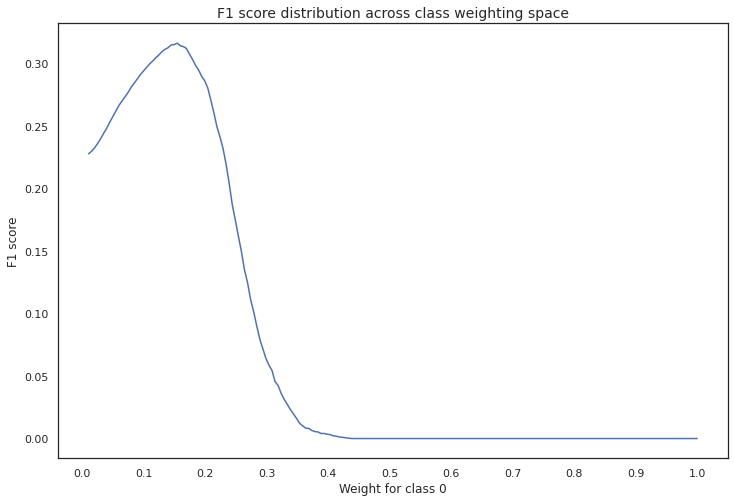

In [13]:
weight_data = pd.DataFrame({'score': gridsearch.cv_results_['mean_test_score'],
                            'weight': (1- weights)})

plt.figure(figsize=(12,8))
sns.set_style('white')
sns.lineplot(x='weight', y='score', data=weight_data)
plt.xlabel('Weight for class 0')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('F1 score distribution across class weighting space', fontsize=14)
plt.show()

In [11]:
print(gridsearch.best_estimator_)

LogisticRegression(C=1.0,
                   class_weight={0: 0.15427135678391957, 1: 0.8457286432160804},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)


## Final Model

The resultant model from this optimisation is presented below, while accounting for class weighting has improved the F1 score of our model, it is still misclassifying a large portion of our dataset. 

This is indicative of two points, either:
- our model is too simplistic to fit our data; or
- the features in our model are of low predictive power.

I believe that currently, the model has too few features to model popularity accurately. For example, an artist name has an impact on a song's number of streams. A mainstream artist will get more streams than an identical release from an indie artist, discounting promotion and marketing differences, simply from their following/fanbase size. Before adjusting my data downloading pipeline, I have built a series of more complex models to confirm this hypothesis.

CLASS WEIGHT: {0: 0.15427135678391957, 1: 0.8457286432160804}
F1 SCORE: 0.30790982640798054
PRECISION: 0.19607843137254902


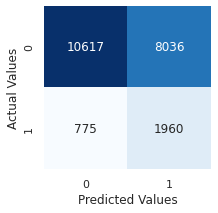

              precision    recall  f1-score   support

         0.0       0.92      0.69      0.79     18653
         1.0       0.22      0.58      0.31      2735

    accuracy                           0.68     21388
   macro avg       0.57      0.64      0.55     21388
weighted avg       0.83      0.68      0.73     21388



In [12]:
max_f1_score = gridsearch.best_score_
opt_weight = weight_data.loc[weight_data['score'] == max_f1_score,
                             'weight'].iloc[0]
optimum_weights = {0: opt_weight, 1: 1-opt_weight}

model = LogisticRegression(solver="newton-cg", class_weight = optimum_weights,
                           max_iter=1000)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(f"CLASS WEIGHT: {optimum_weights}")
print(f"F1 SCORE: {f1_score(y_test, y_pred)}")
print(f"PRECISION: {precision_score(y_test, y_pred, zero_division=0)}")

conf_matrix(y_test, y_pred)

print(classification_report(y_test, predictions))